In [42]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk("/kaggle/input"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [43]:
# df = pd.read_csv("/kaggle/input/hahe-statistics-all-programmes/hahe_all_21_24.csv")
df = pd.read_csv("hahe_all_21_24.csv")

In [44]:
df.head()

,institution,academic_year,program,established,graduate,registered,enrolled,active
0,Athens School of Fine Arts,2020-2021,Fine Arts,03/07/1990,99,1570,140,983
1,Athens School of Fine Arts,2020-2021,Art Theory and History,07/09/2009,116,577,83,443
2,Aristotle University of Thessaloniki,2020-2021,English Language and Literature,03/05/1983,223,1557,227,806
3,Aristotle University of Thessaloniki,2020-2021,Agricultural and Surveying Engineering,24/10/1962,75,937,125,593
4,Aristotle University of Thessaloniki,2020-2021,Architectural Engineering,03/05/1983,142,1297,161,973


# Random Forest

In [55]:
df_rf = df.copy()

# Ensure the target is 'graduates' for forecasting
target = "graduate"

# Sort by academic_year to maintain time order
df_rf = df_rf.sort_values("academic_year")

df_rf["graduate_lag_1"] = df_rf.groupby(["institution", "program"])[
    "graduate"
].shift(1)

df_rf["graduate_lag_2"] = df_rf.groupby(["institution", "program"])[
    "graduate"
].shift(2)

df_rf["graduate_growth"] = (
    df_rf["graduate_lag_1"] - df_rf["graduate_lag_2"]
) / df_rf["graduate_lag_2"]

df_rf = df_rf.replace([np.inf, -np.inf], np.nan)
df_rf = df_rf.dropna().reset_index(
    drop=True
)  # Drop NaN values since they indicate no historical information

# Features: categorical + lag features
features = ["institution", "program", "graduate_lag_1", "graduate_lag_2", "graduate_growth"]
numerical = ["graduate_lag_1", "graduate_lag_2", "graduate_growth"]
categorical = ["institution", "program"]
target = "graduate"

# Split train/test
train_df_rf = df_rf[df_rf["academic_year"] != "2023-2024"]
test_df_rf = df_rf[df_rf["academic_year"] == "2023-2024"]

X_train_rf = train_df_rf[features]
y_train_rf = train_df_rf[target]

X_test_rf = test_df_rf[features]
y_test_rf = test_df_rf[target]

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("num", "passthrough", numerical),
    ]
)

# Random Forest model
model = RandomForestRegressor(n_estimators=300, random_state=42)

pipeline = Pipeline(steps=[("preprocess", preprocessor), ("model", model)])

# Train
pipeline.fit(X_train_rf, y_train_rf)

# Predict
y_pred_rf = pipeline.predict(X_test_rf)

# Evaluate
print("MAE:", mean_absolute_error(y_test_rf, y_pred_rf))
print("R²:", r2_score(y_test_rf, y_pred_rf))


MAE: 31.942761577176213
R²: 0.6966914926399548


# XGBoost

In [68]:
df_xgb = df.copy()
df_xgb = df_xgb.sort_values(
    by=["institution", "program", "academic_year"]
)

df_xgb["graduate_lag_1"] = df_xgb.groupby(["institution", "program"])[
    "graduate"
].shift(1)

df_xgb["graduate_lag_2"] = df_xgb.groupby(["institution", "program"])[
    "graduate"
].shift(2)

df_xgb["graduate_growth"] = (
    df_xgb["graduate_lag_1"] - df_xgb["graduate_lag_2"]
) / df_xgb["graduate_lag_2"]

df_xgb = df_xgb.replace([np.inf, -np.inf], np.nan)
df_xgb = df_xgb.dropna().reset_index(
    drop=True
)  # Drop NaN values since they indicate no historical information

train_df_xgb = df_xgb[df_xgb["academic_year"] != "2023-224"]
test_df_xgb = df_xgb[df_xgb["academic_year"] == "2023-2024"]

features_xgb = [
    "institution",
    "program",
    "registered",
    "enrolled",
    "active",
    "graduate_lag_1",
    "graduate_lag_2",
    "graduate_growth",
]


X_train_xgb = train_df_xgb[features_xgb]
y_train_xgb = train_df_xgb[target]

X_test_xgb = test_df_xgb[features_xgb]
y_test_xgb = test_df_xgb[target]

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

categorical = ["institution", "program"]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("num", "passthrough", numerical),
    ]
)

xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
)

pipeline = Pipeline([("preprocess", preprocessor), ("model", xgb_model)])

pipeline.fit(X_train_xgb, y_train_xgb)
y_pred_xgb = pipeline.predict(X_test_xgb)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test_xgb, y_pred_xgb)
rmse = np.sqrt(mean_squared_error(y_test_xgb, y_pred_xgb))
r2 = r2_score(y_test_xgb, y_pred_xgb)

print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R²   : {r2:.3f}")

MAE  : 7.21
RMSE : 9.33
R²   : 0.988


# Linear Regression

In [62]:
from sklearn.linear_model import LinearRegression

# Copy dataframe
df_linear = df.copy()

# Ensure correct ordering
df_linear = df_linear.sort_values(
    ["institution", "program", "academic_year"]
)

# Create lag features
df_linear["graduate_lag_1"] = (
    df_linear
    .groupby(["institution", "program"])["graduate"]
    .shift(1)
)

df_linear["graduate_lag_2"] = (
    df_linear
    .groupby(["institution", "program"])["graduate"]
    .shift(2)
)

# Drop rows without sufficient history
df_linear = df_linear.dropna()

# Split data
train_df_linear = df_linear[df_linear["academic_year"] < "2023-2024"]
test_df_linear  = df_linear[df_linear["academic_year"] == "2023-2024"]

features = [
    "institution",
    "program",
    "enrolled",
    "registered",
    "active",
    "graduate_lag_1",
    "graduate_lag_2",
]

target = "graduate"

X_train_linear = train_df_linear[features]
y_train_linear = train_df_linear[target]

X_test_linear = test_df_linear[features]
y_test_linear = test_df_linear[target]

categorical = ["institution", "program"]
numerical = [
    "enrolled",
    "registered",
    "active",
    "graduate_lag_1",
    "graduate_lag_2",
]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("num", "passthrough", numerical),
    ]
)

linear_model = Pipeline(
    [("preprocessing", preprocessor), ("regressor", LinearRegression())]
)

linear_model.fit(X_train_linear, y_train_linear)
y_pred_linear = linear_model.predict(X_test_linear)

mse_linear = mean_squared_error(y_test_linear, y_pred_linear)
rmse_linear = np.sqrt(mean_squared_error(y_test_linear, y_pred_linear))
r2_linear = r2_score(y_test_linear, y_pred_linear)

print("Linear Regression:")
print(f"  MSE: {mse_linear:.2f}")
print(f"  RMSE : {rmse_linear:.3f}")
print(f"  R² : {r2_linear:.3f}\n")


Linear Regression:
  MSE: 1824.50
  RMSE : 42.714
  R² : 0.749



# SVR

In [63]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler


df_svr = df.copy()

df_svr = df_svr.sort_values("academic_year")

# Create Lag 1 (previous year)
df_svr["graduate_lag_1"] = df_svr.groupby(["institution", "program"])["graduate"].shift(1)

# Create Lag 2 (two years ago)
df_svr["graduate_lag_2"] = df_svr.groupby(["institution", "program"])["graduate"].shift(2)

# Create Growth Rate
df_svr["graduate_growth"] = (
    df_svr["graduate_lag_1"] - df_svr["graduate_lag_2"]
) / df_svr["graduate_lag_2"]

df_svr = df_svr.replace([np.inf, -np.inf], np.nan)
df_svr = df_svr.dropna().reset_index(drop=True)
categorical = ["institution", "program"]
numerical = [
    "enrolled", 
    "registered", 
    "active", 
    "graduate_lag_1", 
    "graduate_lag_2", 
    "graduate_growth"
]

features = categorical + numerical
target = "graduate"

train_df_svr = df_svr[df_svr["academic_year"] != "2023-2024"]
test_df_svr = df_svr[df_svr["academic_year"] == "2023-2024"]

X_train_svr = train_df_svr[features]
y_train_svr = train_df_svr[target]

X_test_svr = test_df_svr[features]
y_test_svr = test_df_svr[target]

# SVR strictly requires scaling for all numerical inputs
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("num", StandardScaler(), numerical),  # Scale lags/growth too
    ]
)

svr_model = Pipeline(
    [
        ("preprocessing", preprocessor),
        ("regressor", SVR(kernel="rbf", C=1.0, epsilon=0.1)),
    ]
)

svr_model.fit(X_train_svr, y_train_svr)

y_pred_svr = svr_model.predict(X_test_svr)

mse_svr = mean_squared_error(y_test_svr, y_pred_svr)
rmse_svr = np.sqrt(mse_svr)
r2_svr = r2_score(y_test_svr, y_pred_svr)

print("Support Vector Regression (SVR) with Lags:")
print(f"  MSE: {mse_svr:.2f}")
print(f"  RMSE: {rmse_svr:.2f}")
print(f"  R² : {r2_svr:.3f}")

Support Vector Regression (SVR) with Lags:
  MSE: 5333.71
  RMSE: 73.03
  R² : 0.291


# Neural Network

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ institution         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ program             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ academic_year       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_9         │ (None, 1, 15)     │        420 │ institution[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_10        │ (None, 1, 50)     │     12,300 │ program[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_11        │ (None, 1, 3)      │         12 │ academic_year[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_9 (Flatten) │ (None, 15)        │          0 │ embedding_9[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_10          │ (None, 50)        │          0 │ embedding_10[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_11          │ (None, 3)         │          0 │ embedding_11[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numeric_input       │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 75)        │          0 │ flatten_9[0][0],  │
│ (Concatenate)       │                   │            │ flatten_10[0][0], │
│                     │                   │            │ flatten_11[0][0], │
│                     │                   │            │ numeric_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 64)        │      4,864 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 32)        │      2,080 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1)         │         33 │ dense_10[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,709 (76.99 KB)

 Trainable params: 19,709 (76.99 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 16810.1094 - mae: 97.7334 - val_loss: 15303.8486 - val_mae: 93.1823
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 16527.6094 - mae: 96.5962 - val_loss: 14876.6543 - val_mae: 91.5079
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 15839.1631 - mae: 93.8813 - val_loss: 13759.3105 - val_mae: 86.9945
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 13992.7861 - mae: 86.0411 - val_loss: 10743.6660 - val_mae: 74.2899
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9403.4424 - mae: 66.1946 - val_loss: 5693.4883 - val_mae: 54.0152
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4895.0557 - mae: 46.1872 - val_loss: 3001.1594 - val_mae: 42.3312
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2963.9839 - mae: 38.0983 - val_loss: 2110.0715 - val_mae: 35.1360
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2352.7793 - mae: 32.8293 - val_loss: 1793.5145 - val_mae: 32.4112

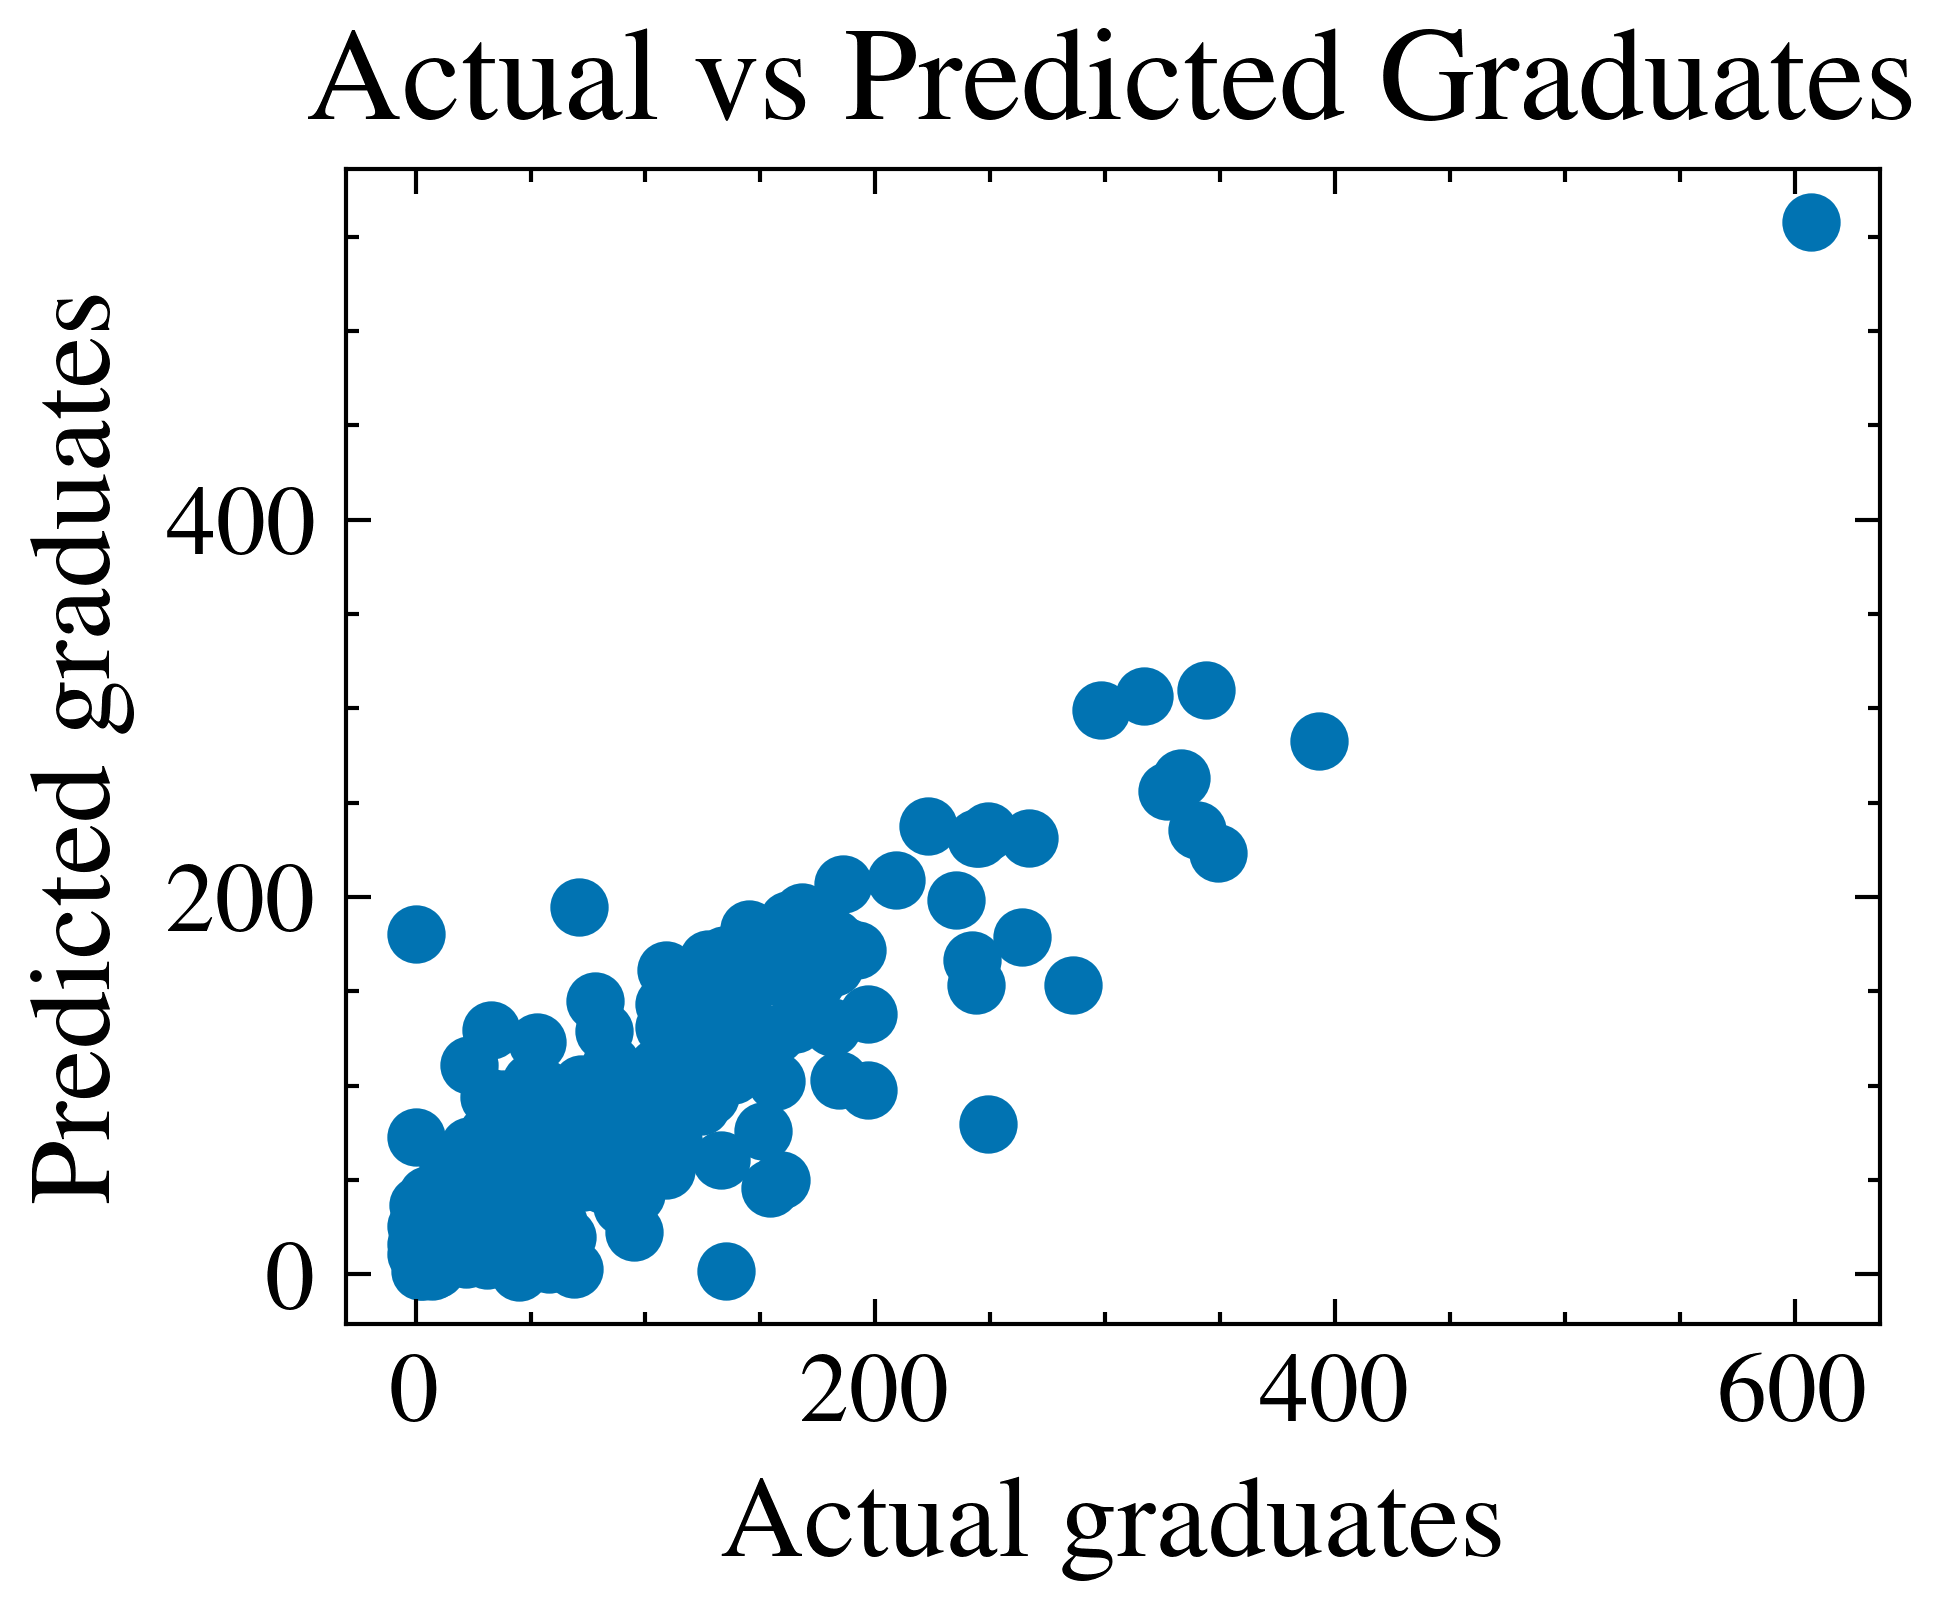

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
MAE: 29.57
RMSE: 41.95
R²: 0.754
Median AE: 21.95


In [64]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Dense,
    Embedding,
    Flatten,
    Concatenate,
    Dropout,
)

df_nn = df.copy()

df_nn["established"] = pd.to_datetime(df_nn["established"], dayfirst=True)
df_nn["years_since_established"] = (
    df_nn["academic_year"].str[:4].astype(int) - df_nn["established"].dt.year
)

df_nn["graduate_lag_1"] = df_nn.groupby(["institution", "program"])["graduate"].shift(1)

df_nn["graduate_lag_2"] = df_nn.groupby(["institution", "program"])["graduate"].shift(2)

df_nn["graduate_growth"] = (df_nn["graduate_lag_1"] - df_nn["graduate_lag_2"]) / df_nn[
    "graduate_lag_2"
]

df_nn = df_nn.replace([np.inf, -np.inf], np.nan)
df_nn = df_nn.dropna().reset_index(
    drop=True
)  # Drop NaN values since they indicate no historical information

# Fill missing values if any
# df_nn.fillna(0, inplace=True)

cat_cols = ["institution", "program", "academic_year"]
cat_maps = {}
for col in cat_cols:
    df_nn[col] = df_nn[col].astype("category")
    df_nn[col + "_id"] = df_nn[col].cat.codes
    cat_maps[col] = dict(enumerate(df_nn[col].cat.categories))

num_cols = [
    "registered",
    "enrolled",
    "active",
    "years_since_established",
    "graduate_lag_1",
    "graduate_lag_2",
    "graduate_growth",
]
X_num = df_nn[num_cols].values
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)

# Target
y = df_nn["graduate"].values

X_train_num, X_test_num, y_train, y_test_nn = train_test_split(
    X_num_scaled, y, test_size=0.2, random_state=42
)

cat_ids = [df_nn[col + "_id"].values for col in cat_cols]
idx_train, idx_test = train_test_split(
    np.arange(len(df_nn)), test_size=0.2, random_state=42
)

X_train_num = X_num_scaled[idx_train]
X_test_num = X_num_scaled[idx_test]

X_train_cat = [df_nn[col + "_id"].values[idx_train] for col in cat_cols]
X_test_cat = [df_nn[col + "_id"].values[idx_test] for col in cat_cols]

y_train = y[idx_train]
y_test_nn = y[idx_test]

embedding_sizes = {
    "institution": min(50, len(cat_maps["institution"]) // 2 + 1),
    "program": min(50, len(cat_maps["program"]) // 2 + 1),
    "academic_year": min(10, len(cat_maps["academic_year"]) // 2 + 1),
}

inputs_cat = []
embeddings = []

for col in cat_cols:
    n_unique = len(cat_maps[col])
    emb_size = embedding_sizes[col]
    inp = Input(shape=(1,), name=col)
    emb = Embedding(input_dim=n_unique, output_dim=emb_size)(inp)
    emb = Flatten()(emb)
    inputs_cat.append(inp)
    embeddings.append(emb)

input_num = Input(shape=(X_num_scaled.shape[1],), name="numeric_input")

x = Concatenate()(embeddings + [input_num])
x = Dense(64, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(32, activation="relu")(x)

output = Dense(1)(x)  # regression output

model = Model(inputs=inputs_cat + [input_num], outputs=output)
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.summary()

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

history = model.fit(
    X_train_cat + [X_train_num],
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
)


loss, mae = model.evaluate(X_test_cat + [X_test_num], y_test_nn)
print("Test MAE:", mae)

y_pred_nn = model.predict(X_test_cat + [X_test_num])

import matplotlib.pyplot as plt

plt.scatter(y_test_nn, y_pred_nn)
plt.xlabel("Actual graduates")
plt.ylabel("Predicted graduates")
plt.title("Actual vs Predicted Graduates")
plt.show()

from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error

y_pred_nn = model.predict(X_test_cat + [X_test_num]).squeeze()

mae = np.mean(np.abs(y_test_nn - y_pred_nn))
rmse = np.sqrt(mean_squared_error(y_test_nn, y_pred_nn))
r2 = r2_score(y_test_nn, y_pred_nn)
medae = median_absolute_error(y_test_nn, y_pred_nn)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")
print(f"Median AE: {medae:.2f}")

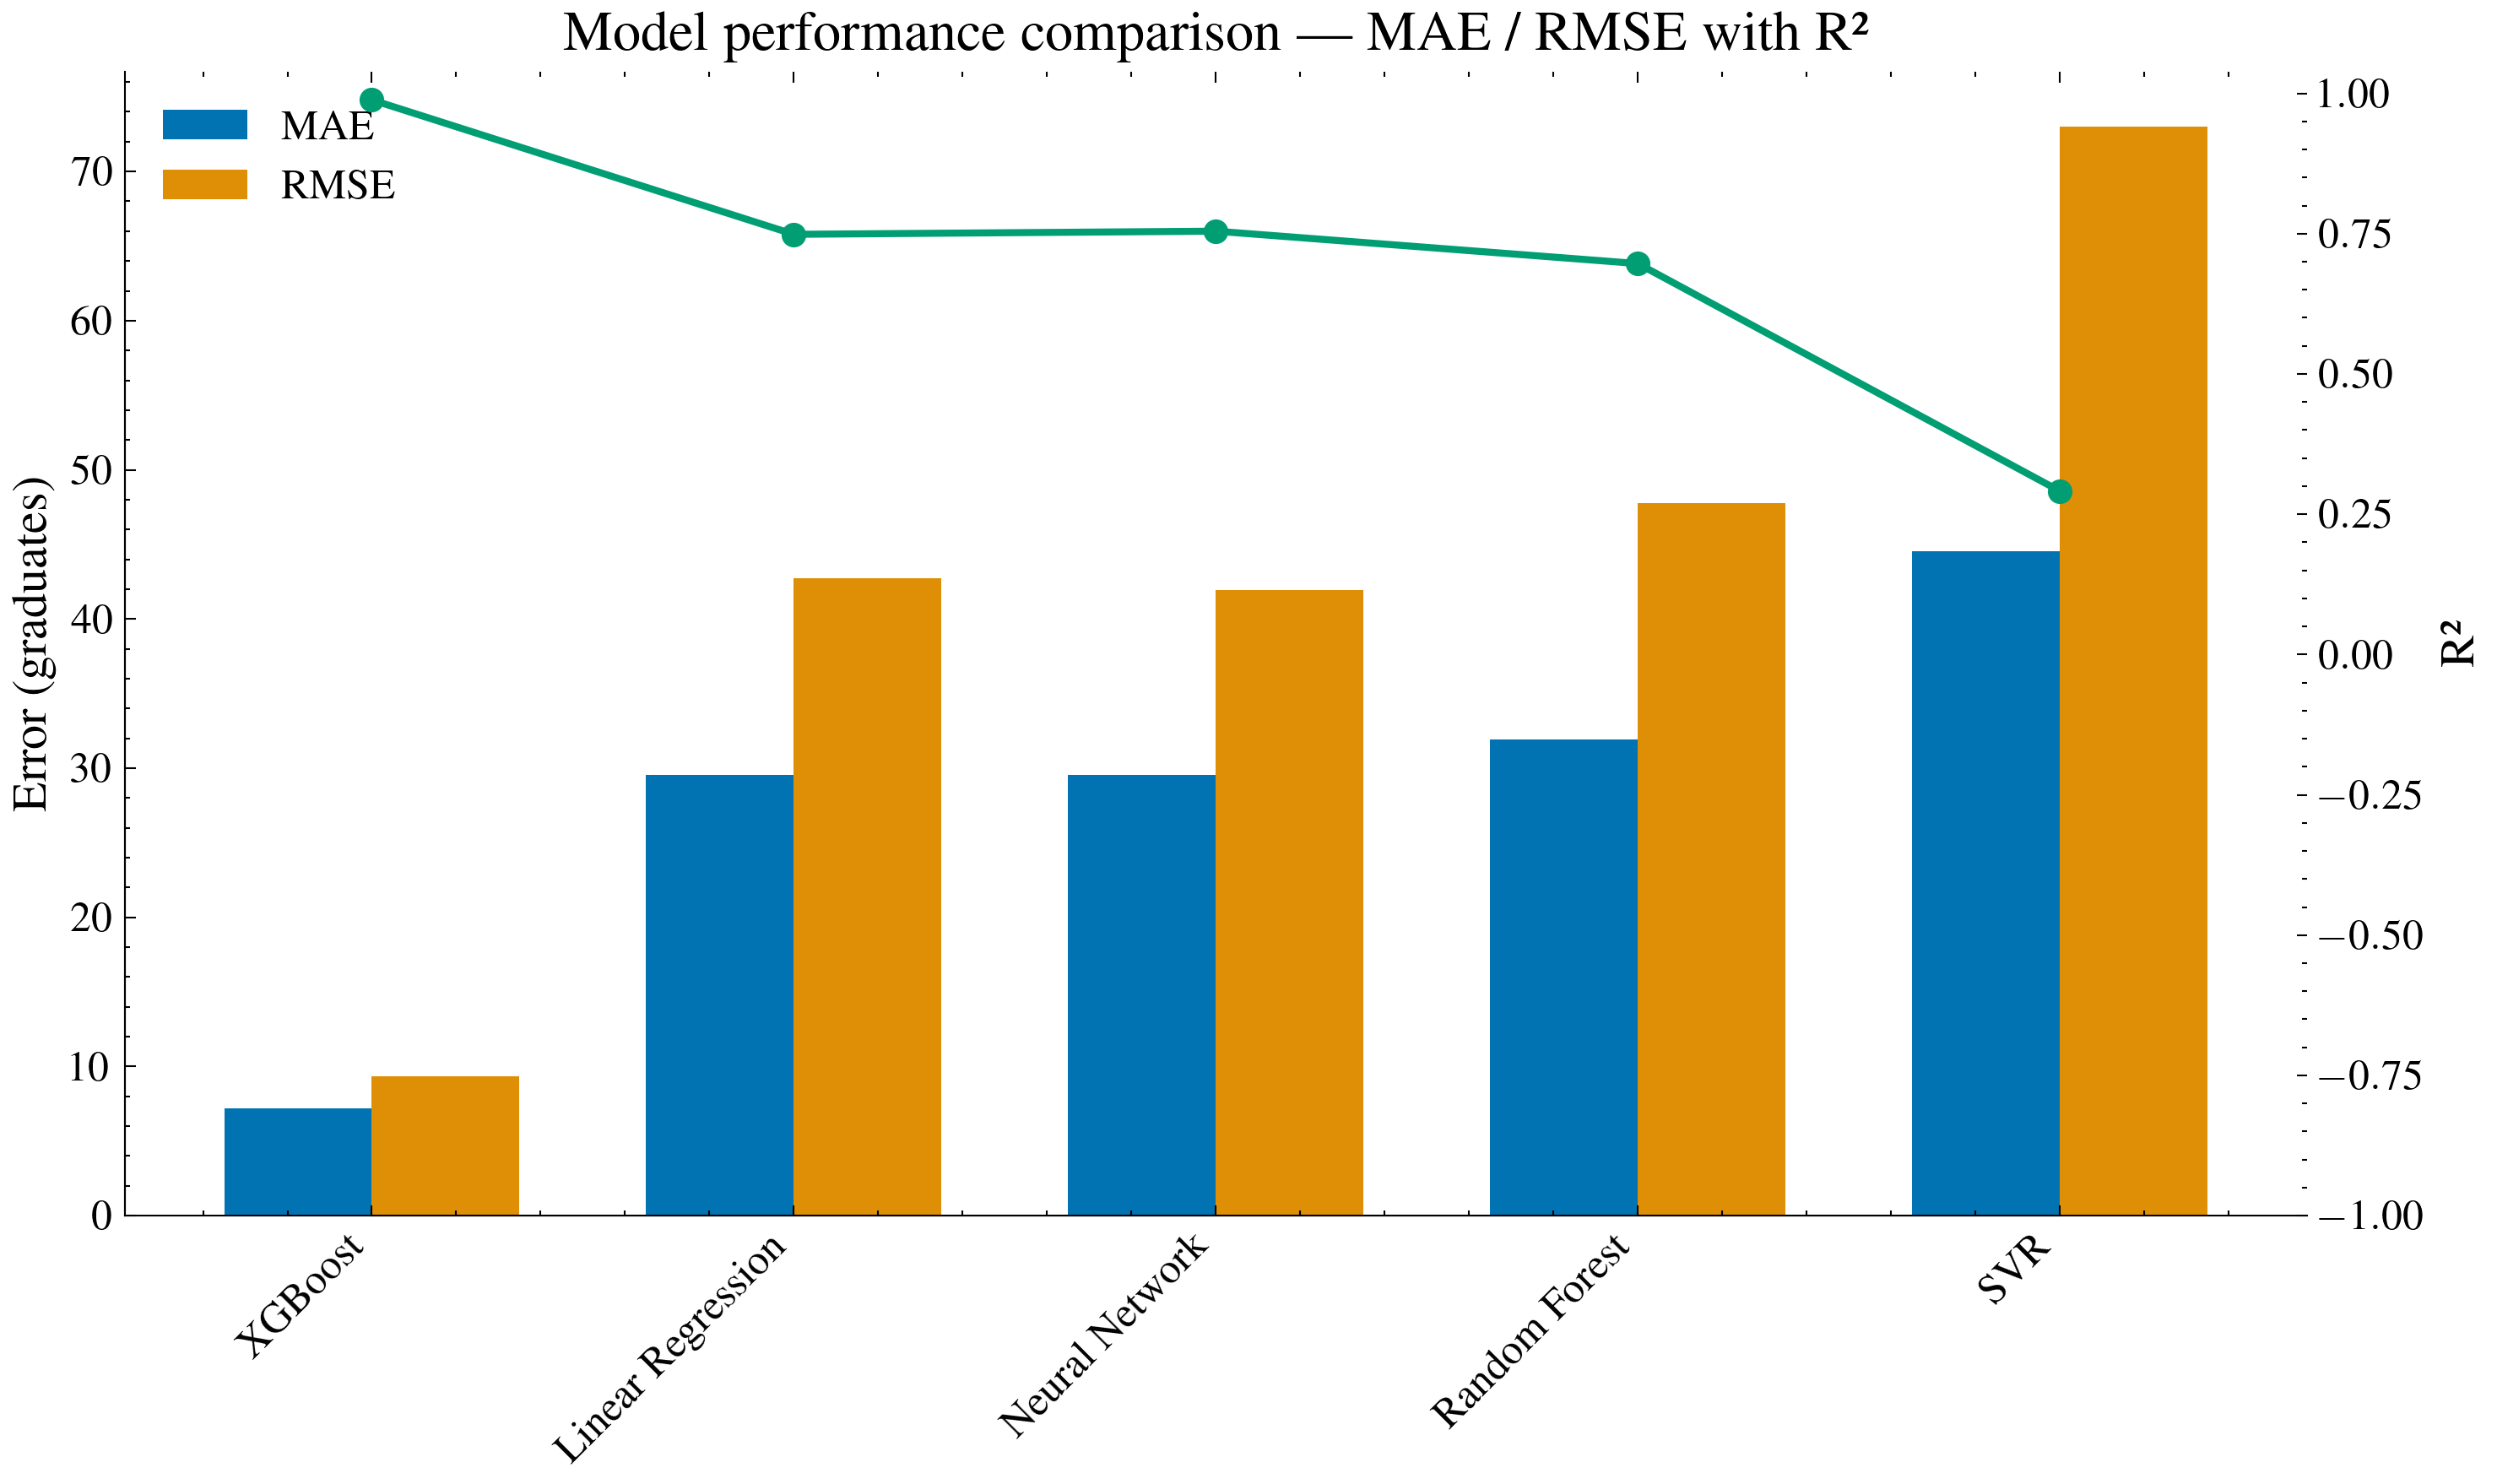

In [70]:
# Model comparison plot: MAE / RMSE (bars) with R² overlay; save PDF/PNG at 300 DPI
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Fonts and sizes (Times-like serif)
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times New Roman', 'Times', 'DejaVu Serif']
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
# Try to use scienceplots for a Nature/Science style, fallback to clean seaborn style
try:
    import scienceplots
    plt.style.use(['science', 'ieee'])
except Exception:
    plt.style.use('seaborn-whitegrid')
# Accessible, colorblind-friendly palette
palette = sns.color_palette('colorblind')
sns.set_palette(palette)
# Helper to collect models that were run earlier in the notebook (if available)
models = {}
def safe_add(name, y_true, y_pred):
    try:
        yt = np.asarray(y_true)
        yp = np.asarray(y_pred)
        if yt.shape[0] != yp.shape[0]:
            return
        models[name] = {'y_true': yt, 'y_pred': yp}
    except Exception:
        return
# Known prediction variable names used in this notebook; will skip missing ones
pairs = [
    ('Random Forest', 'y_test_rf', 'y_pred_rf'),
    ('XGBoost', 'y_test_xgb', 'y_pred_xgb'),
    ('Linear Regression', 'y_test_linear', 'y_pred_linear'),
    ('SVR', 'y_test_svr', 'y_pred_svr'),
    ('Neural Network', 'y_test_nn', 'y_pred_nn'),
]
for name, y_var, yp_var in pairs:
    y_true = globals().get(y_var, None)
    y_pred = globals().get(yp_var, None)
    if y_true is not None and y_pred is not None:
        safe_add(name, y_true, y_pred)
# Compute metrics for each model
metrics = []
for name, vals in models.items():
    y_true = vals['y_true']
    y_pred = vals['y_pred']
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    metrics.append((name, mae, rmse, r2))
if not metrics:
    print('No model predictions found in the notebook namespace. Run the model cells first.')
else:
    df_metrics = pd.DataFrame(metrics, columns=['model','MAE','RMSE','R2']).set_index('model')
    # Sort by MAE for visual clarity
    df_metrics = df_metrics.sort_values('MAE')
    fig, ax1 = plt.subplots(figsize=(10, 6), dpi=300)
    width = 0.35
    x = np.arange(len(df_metrics))
    ax1.bar(x - width/2, df_metrics['MAE'], width, label='MAE', color=palette[0])
    ax1.bar(x + width/2, df_metrics['RMSE'], width, label='RMSE', color=palette[1])
    ax1.set_ylabel('Error (graduates)', fontsize=14)
    ax1.set_xticks(x)
    ax1.set_xticklabels(df_metrics.index, rotation=45, ha='right', fontsize=12)
    ax1.tick_params(axis='y', labelsize=12)
    ax1.legend(loc='upper left', fontsize=12)
    sns.despine(ax=ax1, trim=True)
    # Secondary axis for R² (line)
    ax2 = ax1.twinx()
    ax2.plot(x, df_metrics['R2'], color=palette[2], marker='o', linewidth=2, label='R²')
    ax2.set_ylabel('R²', fontsize=14)
    ax2.tick_params(axis='y', labelsize=12)
    # Set reasonable R² limits
    ymin = min(-1, df_metrics['R2'].min() - 0.05)
    ymax = max(1, df_metrics['R2'].max() + 0.05)
    ax2.set_ylim(ymin, ymax)
    # Remove top/right spines for clarity
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax1.set_title('Model performance comparison — MAE / RMSE with R²', fontsize=16)
    plt.tight_layout()
    out_dir = 'figures-refactored/'
    os.makedirs(out_dir, exist_ok=True)
    pdf_path = os.path.join(out_dir, 'model_comparison.pdf')
    png_path = os.path.join(out_dir, 'model_comparison.png')
    fig.savefig(pdf_path, dpi=300, bbox_inches='tight')
    fig.savefig(png_path, dpi=300, bbox_inches='tight')
    plt.show()